# Performance shootout - python libraries for computer vision (Part 1/2)

**Update 2017-02-03**

Updated to latest versions of opencv/mahotas/skimage

---------------------

What are the fastest libraries for image processing or computer vision that provide python as the front-end API? In this post, we will discuss some of the simplest image operations, and see how different libraries perform  in terms of speed. Note that we are interested in speed only, and not the actual output of the operations performed. This is because the image operations that we are using for the post are typically pre-processing step for end-applications (and evaluation metric might differ in different applications)

## 1. Contestants

We boiled down to following three most popular computer vision libraries. (Few others who didn't make it to the list - [VLFeat](http://www.vlfeat.org/), [SimpleCV](http://simplecv.org/), [SimpleITK](http://www.simpleitk.org/), [ilastik](http://ilastik.org/))

### 1.1 OpenCV
Probably the most popular and commonly use computer vision library. It is written primarily in C++ but has bindings for Matlab, Python and Java. **Pros** - runs on variety of platforms (Windows/Linux/OSX, Android, iOS), fast, large active community support. **Cons** - lack of documentation for latest python APIs, lots of dependencies, less backward compatibility.

### 1.2 mahotas
Again a fast library as most of its algorithms are written in C++, mahotas is optimal choice for developers from python background with its clean python interface and seemless operations with numpy arrays. **Pros** - large number of implemented algorithms, clean python interface, C++ backend for speed, numpy integration. **Cons** - smaller community

### 1.3 skimage
Most popular computer vision library amid Python users. **Pros** - integrates well with other python package like sklearn/scipy. **Cons** - fewer algorithms implemented.

## 2. operations

We are going to evaulate following basic operations for image processing

- read (jpeg) image file to numpy array
- erosion
- dilation
- open
- close
- sobel
- watershed

## 3. boilerplate stuff

Some functions we'll be using for plotting. Also specifying some image paths (modify them as necessary)

In [13]:
import os
import numpy as np
import timeit
import cv2, mahotas, skimage, skimage.morphology
from pylab import imshow, show

import matplotlib.pyplot as plt
%matplotlib inline

lena_path = 'pershoot/lena.jpeg'

def pyplots(f1, f2, f3, f4, cmap='gray', scatter=False):
    plt.figure(figsize=(10,10))
    plt.subplot(1, 4, 1)
    plt.imshow(f1, cmap=cmap)
    plt.axis('off')
    if scatter:
        plt.scatter(x=[100, 200], y=[100, 200], c='r', s=40)
    
    for index, im in enumerate([f2, f3, f4]):
        plt.subplot(1, 4, index+2)
        if cmap is not None:
            plt.imshow(im, cmap=cmap)
        else:
            plt.imshow(im)
        plt.axis('off')

### erode

kind of making thick lines skinny

93


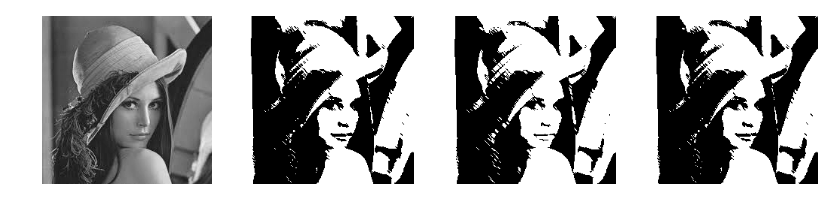

In [5]:
fRGB = mahotas.imread(lena_path).astype(np.uint8)
f64 = mahotas.imread(lena_path, as_grey=True)
f = f64.astype(int)

otsu = mahotas.otsu(f.astype(np.uint8))
print(otsu)
fbin = f > otsu
fbin8 = fbin.astype(np.uint8)

Bc = np.eye(3)
Bc = Bc.astype(bool)
Bc8 = Bc.astype(np.uint8)

fMH = mahotas.erode(fbin, Bc)
fSK = skimage.morphology.opening(fbin8, Bc8)
fCV = cv2.erode(fbin8, Bc8)

pyplots(f, fMH, fSK, fCV)

### dilate

making thin lines thicker

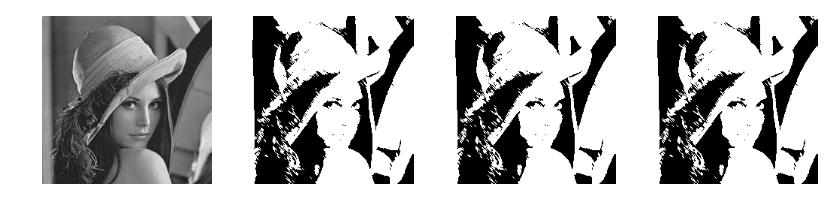

In [6]:
fMH = mahotas.dilate(fbin, Bc)
fSK = skimage.morphology.dilation(fbin8, Bc8)
fCV = cv2.dilate(fbin8, Bc8)

pyplots(f, fMH, fSK, fCV)

### open

erosion followed by dilation; removes thin (noisy) lines/holes

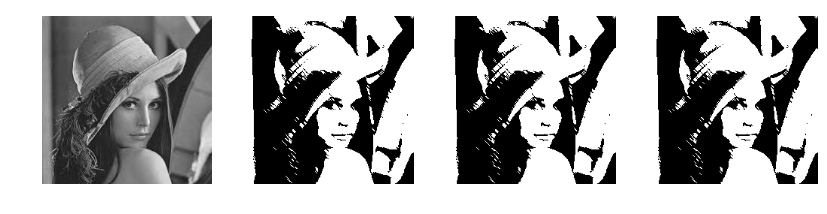

In [7]:
fMH = mahotas.open(fbin, Bc)
fSK = skimage.morphology.opening(fbin8, Bc8)
fCV = cv2.morphologyEx(fbin8, cv2.MORPH_OPEN, Bc8)

pyplots(f, fMH, fSK, fCV)

### close

dilation followed by erosion; fills up small holes in the image

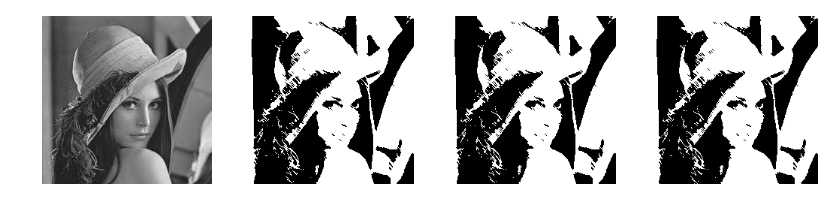

In [8]:
fMH = mahotas.close(fbin, Bc)
fSK = skimage.morphology.closing(fbin8, Bc8)
fCV = cv2.morphologyEx(fbin8, cv2.MORPH_CLOSE, Bc8)

pyplots(f, fMH, fSK, fCV)

### sobel

sobel edge detection (read more [here](https://en.wikipedia.org/wiki/Sobel_operator))

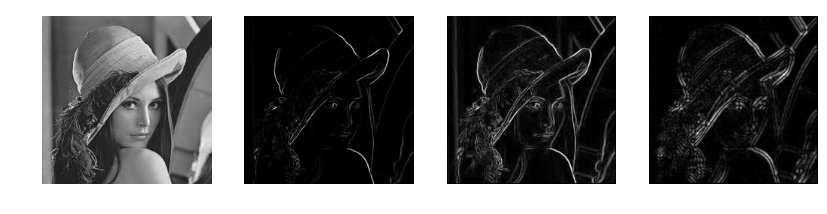

In [30]:
fMH = mahotas.sobel(f64, just_filter=True)
fSK = skimage.filters.sobel(f64)
fCV = np.absolute(cv2.Sobel(f64,cv2.CV_64F,1,1, ksize=11))

pyplots(f, fMH, fSK, fCV)

### watershed

background removal (read more [here](https://en.wikipedia.org/wiki/Watershed_(image_processing)))

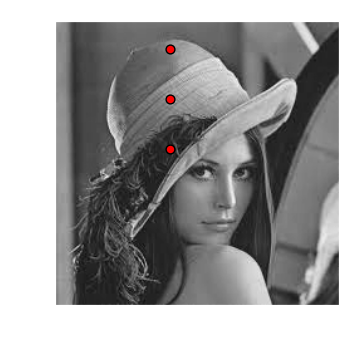

In [43]:
markers = np.zeros_like(f)
markers[90,100] = 1
markers[90,20] = 2
markers[90,60] = 3
markers = markers.astype(np.int32)

#fMH = mahotas.cwatershed(f, markers)
#fSK = skimage.morphology.watershed(f, markers)
#fCV = cv2.watershed(fRGB, markers)

#pyplots(f, fMH, fSK, fCV, cmap='gray', scatter=True)

plt.imshow(f, cmap='gray')
plt.axis("off")
plt.scatter(x=[90, 90, 90],
            y=[100, 20, 60],
            c='r', s=40)

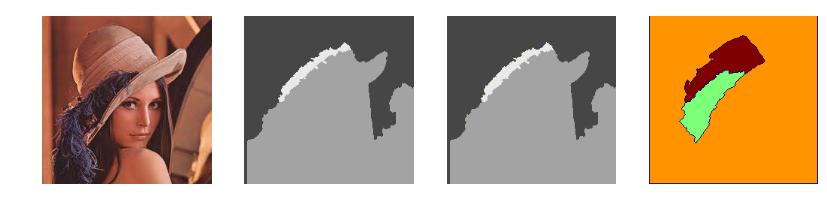

In [72]:
marker3d = np.zeros_like(fRGB)
marker3d[90,100,:] = [1,1,1]
marker3d[90,20,:] = [2,2,2]
marker3d[90,60,:] = [3,3,3]
marker3d = marker3d.astype(np.int32)

marker = np.zeros_like(f)
marker[90,100] = 1
marker[90,20] = 2
marker[90,60] = 3
marker = marker.astype(np.int32)

fMH = mahotas.cwatershed(fRGB, marker3d)
fMH *= otsu
fMH = fMH.astype(np.int32)
fSK = skimage.morphology.watershed(fRGB, marker3d)
fSK *= otsu
fSK = fSK.astype(np.int32)
fCV = cv2.watershed(fRGB, marker)
fCV += 1
fCV *=otsu

pyplots(fRGB, fMH, fSK, fCV, cmap='jet')

## mahotas vs skimage vs opencv

In [83]:
pre ='''
import numpy as np
import cv2, mahotas, skimage
from skimage.feature import greycomatrix, greycoprops

lena_path = 'pershoot/lena.jpeg'
fRGB = mahotas.imread(lena_path, as_grey=False)
f64 = mahotas.imread(lena_path, as_grey=True)
f = f64.astype(int)

marker3d = np.zeros_like(fRGB)
marker3d[90,100,:] = [1,1,1]
marker3d[90,20,:] = [2,2,2]
marker3d[90,60,:] = [3,3,3]
marker3d = marker3d.astype(np.int32)

marker = np.zeros_like(f)
marker[90,100] = 1
marker[90,20] = 2
marker[90,60] = 3
marker = marker.astype(np.int32)

otsu = mahotas.otsu(f.astype(np.uint8))
fbin = f > otsu
fbin8 = fbin.astype(np.uint8)

Bc = np.eye(3)
Bc = Bc.astype(bool)
Bc8 = Bc.astype(np.uint8)
'''

In [92]:
import sys

def t(s):
    return timeit.timeit(s, setup=pre, number=10)

tests = [
    ('erode', [
        'mahotas.erode(fbin, Bc)',
        'skimage.morphology.opening(fbin8, Bc8)',
        'cv2.erode(fbin8, Bc8)',
        ]),
    ('dilate', [
        'mahotas.dilate(fbin, Bc)',
        'skimage.morphology.dilation(fbin8, Bc8)',
        'cv2.dilate(fbin8, Bc8)',
        ]),
    ('open', [
        'mahotas.open(fbin, Bc)',
        'skimage.morphology.opening(fbin8, Bc8)',
        'cv2.morphologyEx(fbin8, cv2.MORPH_OPEN, Bc8)',
        ]),
    ('close', [
        'mahotas.close(fbin, Bc)',
        'skimage.morphology.closing(fbin8, Bc8)',
        'cv2.morphologyEx(fbin8, cv2.MORPH_CLOSE, Bc8)',
        ]),
    ('sobel', [
        'mahotas.sobel(f)',
        'skimage.filters.sobel(f64)',
        'cv2.Sobel(f64,cv2.CV_64F,1,1)',
        ]),
    ('cwatershed', [
        'mahotas.cwatershed(fRGB, marker3d)',
        'skimage.morphology.watershed(fRGB, marker3d)',
        'cv2.watershed(fRGB, marker)',
        ]),
    ('haralick', [
        'mahotas.features.haralick(f)',
        'greycoprops(greycomatrix(f, [1], [0]))',
        None,
        ]),
]

print(r'%-12s|%9s |%9s |%9s |' % ('Algorithm', 'mahotas','skimage','opencv'))
for name,statements in tests:
    sys.stdout.write(r'%-12s|' % name),
    for st in statements:
        if st is None:
            sys.stdout.write('      NA |'),
        else:
            time = '%.4f' % (t(st))
            sys.stdout.write('%8s |' % time),
    sys.stdout.write('\n')


Algorithm   |  mahotas |  skimage |   opencv |
erode       |  0.0006 |  0.0208 |  0.0003 |
dilate      |  0.0002 |  0.0096 |  0.0003 |
open        |  0.0005 |  0.0176 |  0.0005 |
close       |  0.0005 |  0.0174 |  0.0007 |
sobel       |  0.0485 |  0.0230 |  0.0022 |
cwatershed  |  0.9176 |  0.7912 |  0.0030 |
haralick    |  0.2126 |  0.0182 |      NA |


**AND we have a winner**

OpenCV outperforms mahotas and skimage (by an order of manitude).

I performed a bit experimentation computing more intensive image features like haralick features and hu moments. Will share my findings in the next blog.

Happy learning by coding!